In [1]:
# First of all, you need to require the OACIS environment. Always run the following line before you call the OAICS APIs.
require File.join(ENV['OACIS_ROOT'], 'config/environment')

true

# Prerequisites

Before running the following samples, please prepare a sample simulator as follows.

- Name: `sample_simulator`
- Parameter definitions:
    - "p1", Float, 1.0
    - "p2", Float, 2.0
    - "p3", Float, 3.0
- Command:
    - `ruby -r json -e 'j = JSON.load(File.read("_input.json")); sum=%w(p1 p2 p3).map{|k| j[k]}.inject(:+); puts({sum: sum}.to_json)' > _output.json`
- Input type: JSON
- Executable_on : localhost

# Creating runs

First, we show how to create parameter sets and runs.

In [2]:
sim = Simulator.where(name: "sample_simulator").first
ps = sim.find_or_create_parameter_set( {"p1"=>10.0, "p2"=>20.0, "p3"=>30.0} )  # created a parameter set

#<ParameterSet _id: 58060d0b3192d59f5b14f03b, created_at: 2016-10-18 11:52:43 UTC, updated_at: 2016-10-18 11:52:43 UTC, v: {"p1"=>10.0, "p2"=>20.0, "p3"=>30.0}, runs_status_count_cache: nil, progress_rate_cache: nil, to_be_destroyed: false, simulator_id: BSON::ObjectId('58060cf93192d50d8b0bbad5')>

In [3]:
# When creating runs, you need to specify the host to which the jobs are submitted to.
# We also need to set "host_parameters" which specify the parameters required by job schedulers.

host = Host.where(name: "localhost").first
host_param = host.default_host_parameters
new_runs = ps.find_or_create_runs_upto(5, submitted_to: host, host_param: host_param )
new_run_ids = new_runs.map(&:id)

[BSON::ObjectId('58060d0e3192d59f5b14f03c'), BSON::ObjectId('58060d0e3192d59f5b14f03d'), BSON::ObjectId('58060d0e3192d59f5b14f03e'), BSON::ObjectId('58060d0e3192d59f5b14f03f'), BSON::ObjectId('58060d0e3192d59f5b14f040')]

In [4]:
# A sample to make multiple parameter sets

sim = Simulator.where(name: "sample_simulator").first

p1_values = [1.0,2.0,3.0,4.0,5.0]                                         # a standard way to make an array
p2_values = 2.0.step(20.0, 2.0)                                            # Numeric#step method is also useful to make an enumerator. 2.0, 4.0, 6.0, ... 20.0
base_param = sim.default_parameters                                  # => {"p1"=>1.0, "p2"=>2.0, "p3"=>3.0}

host = Host.where(name: "localhost").first
host_param = host.default_host_parameters

created = []

# We are going to fix the parameters other than "p1" and "p2"
p1_values.each do |p1|                  # iterate over p1
  p2_values.each do |p2|                # iterate over p2
    param = base_param.merge({"p1"=>p1,"p2"=>p2})    #   => {"p1"=>p1, "p2"=>p2, "p3"=>3.0}
    ps = sim.find_or_create_parameter_set( param )          #   => ParameterSet of the given parameters
    runs = ps.find_or_create_runs_upto(5, submitted_to: host, host_param: host_param)  # creating runs under given parameter sets
    created += runs                           # pushing runs into an array to refer them later
  end
end

created.size                                     # 250 runs are created in total

250

# Getting the results

Here, we are going to investigate the dependency of "p1" and "p2" against the results.
Run the below cells after the above jobs are finished.

In [7]:
# First, let us try to get runs by specifying parameters.
sim = Simulator.where(name: "sample_simulator").first

# Accessing the attributes of simulator
p sim.name
p sim.command
p sim.executable_on.map(&:name)

# count the number of runs of this simulator
p sim.runs.count
p sim.runs.where(status: :finished).count

"sample_simulator"
"ruby -r json -e 'j = JSON.load(File.read(\"_input.json\")); sum=%w(p1 p2 p3).map{|k| j[k]}.inject(:+); puts({sum: sum}.to_json)' > _output.json"
["localhost"]
255
255


255

In [8]:
# ParameterSet of {p1: 1.0, p2: 2.0, p3: 3.0}
sim = Simulator.where(name: "sample_simulator").first
ps = sim.find_parameter_set( p1: 1.0, p2: 2.0, p3: 3.0 )

#  Here are some examples of fields of ParameterSet
p ps.id
p ps.v                                                                         # values of parameters are stored in the field `v` as a Hash
p ps.runs.count                                                         # number of runs
p ps.runs.where( status: :finished ).count            # number of finished runs
p ps.average_result("sum")                                   # => [6.0, 5].  It returns the average of result["sum"] and the number of runs

BSON::ObjectId('58060d113192d59f5b14f041')
{"p1"=>1.0, "p2"=>2.0, "p3"=>3.0}
5
5
[6.0, 5]


[6.0, 5]

In [9]:
# Get a Run
sim = Simulator.where(name: "sample_simulator").first
ps = sim.find_parameter_set( p1: 1.0, p2: 2.0, p3: 3.0 )
run = ps.runs.first

# Here are some examples of fields of Run
p run.id                               # returns ID
p run.status                       # status can be either [:created, :submitted, :running, :failed, :finished]
p run.result                        # =>{"sum"=>6.0}   If the simulator print `_output.json` during the job, the contents of the file are stored in this field.
p run.cpu_time                  # `cpu_time` and `real_time`  methods are available to get the CPU and elapsed times.
p run.finished_at               # the datetime when the job is finished.
p run.dir                              # return the directory where the simulation results are stored.

BSON::ObjectId('58060d113192d59f5b14f042')
:finished
{"sum"=>6.0}
0.03
Tue, 18 Oct 2016 11:53:01 +0000
#<Pathname:/Users/murase/work/oacis/public/Result_development/58060cf93192d50d8b0bbad5/58060d113192d59f5b14f041/58060d113192d59f5b14f042>


#<Pathname:/Users/murase/work/oacis/public/Result_development/58060cf93192d50d8b0bbad5/58060d113192d59f5b14f041/58060d113192d59f5b14f042>

In [10]:
# Search parameter sets by condition
sim = Simulator.where(name: "sample_simulator").first

# The followings are some example queries which you might find useful.
# Since a ParameterSet contains the parameters in the field of `v`, you need to issue an query against `v`.
# See http://www.rubydoc.info/github/mongoid/origin/Origin/Selectable

# Find ParameterSets where p2 is 10.0 and p3 is 3.0.
puts "p2 == 10.0 and p3 == 3.0"
sim.parameter_sets.where( "v.p2"=> 10.0, "v.p3" => 3.0 ).each {|ps| p ps.v }
puts ""

# examples of other conditions, such as ">=" or ">".
puts "p1 <= 2 and p2 > 15.0 and p3 == 3.0"
sim.parameter_sets.lte( "v.p1"=> 2 ).gt( "v.p2" => 15.0 ).where("v.p3" => 3.0).each {|ps| p ps.v }
puts ""

# p1 is in the range 2..4"
puts "p1 is in [2,4] and 4.5 and p2==20"
sim.parameter_sets.in("v.p1" => [2,4]).where("v.p2" => 20).each {|ps| p ps.v }
puts ""

# sort by p1 in ascending order
puts "p1 <= 3 and p2 <= 6.0, ordered by p1 in ascending order and p2 in descending order"
sim.parameter_sets.lte( "v.p1" => 3, "v.p2" => 6.0 ).order_by("v.p1" => :asc, "v.p2" => :dsc).each {|ps| p ps.v }
puts ""

p2 == 10.0 and p3 == 3.0
{"p1"=>1.0, "p2"=>10.0, "p3"=>3.0}
{"p1"=>2.0, "p2"=>10.0, "p3"=>3.0}
{"p1"=>3.0, "p2"=>10.0, "p3"=>3.0}
{"p1"=>5.0, "p2"=>10.0, "p3"=>3.0}
{"p1"=>4.0, "p2"=>10.0, "p3"=>3.0}

p1 <= 2 and p2 > 15.0 and p3 == 3.0
{"p1"=>1.0, "p2"=>20.0, "p3"=>3.0}
{"p1"=>1.0, "p2"=>18.0, "p3"=>3.0}
{"p1"=>1.0, "p2"=>16.0, "p3"=>3.0}
{"p1"=>2.0, "p2"=>16.0, "p3"=>3.0}
{"p1"=>2.0, "p2"=>18.0, "p3"=>3.0}
{"p1"=>2.0, "p2"=>20.0, "p3"=>3.0}

p1 is in [2,4] and 4.5 and p2==20
{"p1"=>2.0, "p2"=>20.0, "p3"=>3.0}
{"p1"=>4.0, "p2"=>20.0, "p3"=>3.0}

p1 <= 3 and p2 <= 6.0, ordered by p1 in ascending order and p2 in descending order
{"p1"=>1.0, "p2"=>2.0, "p3"=>3.0}
{"p1"=>1.0, "p2"=>4.0, "p3"=>3.0}
{"p1"=>1.0, "p2"=>6.0, "p3"=>3.0}
{"p1"=>2.0, "p2"=>2.0, "p3"=>3.0}
{"p1"=>2.0, "p2"=>4.0, "p3"=>3.0}
{"p1"=>2.0, "p2"=>6.0, "p3"=>3.0}
{"p1"=>3.0, "p2"=>2.0, "p3"=>3.0}
{"p1"=>3.0, "p2"=>4.0, "p3"=>3.0}
{"p1"=>3.0, "p2"=>6.0, "p3"=>3.0}



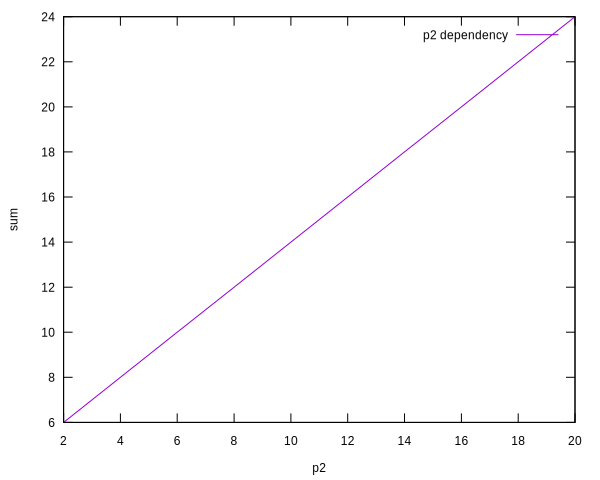

In [32]:
# plot results using Gnuplot
require 'gnuplotrb'

sim = Simulator.where(name: "sample_simulator").first

dat_file = "ps_sum_plot.dat"
io = File.open( dat_file, 'w')
sim.parameter_sets.where("v.p1"=>1.0, "v.p3"=>3.0).order_by("v.p2" => :asc).each do |ps|
  x = ps.v["p2"]
  y = ps.average_result("sum").first
  io.puts [x,y].join(' ')
end
io.close
GnuplotRB::Plot.new([dat_file , with: 'lines', title: 'p2 dependency'], xlabel: "p2", ylabel: "sum")


# Deleting items

We are going to demonstrate how to delete unnecessary items in OACIS.

In [38]:
# call discard method to delete an item

sim = Simulator.where(name: "sample_simulator").first
ps = sim.find_parameter_set( "p1"=>1.0, "p2" => 2.0, "p3" => 3.0 )
puts ps.runs.count                                       # => 5
run = ps.runs.first                                         # Get the first run
run.discard                                                     # Delete it
puts ps.runs.count                                       # => 4.  The number of runs is decreased by 1.


#  deleting all ParameterSet whose p2 is larger than 10.0
p sim.parameter_sets.gt("v.p2" => 10.0).exists?             # => true
sim.parameter_sets.gt( "v.p2" => 10.0 ).each do |ps|
  ps.discard
end
sim.parameter_sets.gt("v.p2" => 10.0).exists?             # => false
# Visit the page of OACIS and verify that ParameterSets have been deleted.

NoMethodError: undefined method `runs' for nil:NilClass